In [1]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import tensorflow as tf # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.preprocessing import StandardScaler # type: ignore
from sklearn.metrics import classification_report, confusion_matrix # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore

In [2]:
# Load the data
df = pd.read_csv('Churn.csv')

In [3]:

# Initial inspection
print("Initial data shape:", df.shape)

Initial data shape: (7044, 21)


In [4]:
print("\nMissing values:\n", df.isnull().sum())


Missing values:
 Customer ID          0
Gender               0
Senior Citizen       0
Partner              0
Dependents           0
tenure               0
Phone Service        0
Multiple Lines       0
Internet Service     0
Online Security      0
Online Backup        0
Device Protection    0
Tech Support         0
Streaming TV         0
Streaming Movies     0
Contract             0
Paperless Billing    0
Payment Method       0
Monthly Charges      0
Total Charges        0
Churn                0
dtype: int64


In [5]:
print("\nData types:\n", df.dtypes)


Data types:
 Customer ID           object
Gender                object
Senior Citizen         int64
Partner               object
Dependents            object
tenure                 int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges         object
Churn                 object
dtype: object


In [6]:
# Handle missing values - only one in Total Charges which appears to be a new customer (tenure=0)
df['Total Charges'] = df['Total Charges'].replace(' ', np.nan).astype(float)
df['Total Charges'] = df['Total Charges'].fillna(0)

In [7]:
# Drop customer ID as it's not useful for modeling
df = df.drop('Customer ID', axis=1)

In [8]:

# Convert binary categorical variables to numeric
binary_cols = ['Gender', 'Partner', 'Dependents', 'Phone Service', 'Paperless Billing', 'Churn']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0, 'Female': 1, 'Male': 0})

In [9]:

# Handle 'Multiple Lines' and other similar columns with 'No phone service' option
df['Multiple Lines'] = df['Multiple Lines'].map({'Yes': 1, 'No': 0, 'No phone service': 0})

In [10]:
# Handle internet service related columns
internet_cols = ['Online Security', 'Online Backup', 'Device Protection', 
                 'Tech Support', 'Streaming TV', 'Streaming Movies']
for col in internet_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0, 'No internet service': 0})

In [11]:
# Convert 'Contract' to numerical (Month-to-month: 0, One year: 1, Two year: 2)
df['Contract'] = df['Contract'].map({'Month-to-month': 0, 'One year': 1, 'Two year': 2})

In [12]:
# Convert 'Payment Method' to numerical using one-hot encoding
payment_dummies = pd.get_dummies(df['Payment Method'], prefix='Payment')
df = pd.concat([df, payment_dummies], axis=1)
df = df.drop('Payment Method', axis=1)

In [13]:

# Convert 'Internet Service' to numerical (No: 0, DSL: 1, Fiber optic: 2)
df['Internet Service'] = df['Internet Service'].map({'No': 0, 'DSL': 1, 'Fiber optic': 2})

In [14]:
# Ensure all columns are numeric
for col in df.columns:
    if df[col].dtype == 'object':
        print(f"Column {col} still has object type - needs conversion")

In [15]:
# Final check for missing values
print("\nMissing values after cleaning:\n", df.isnull().sum())


Missing values after cleaning:
 Gender                               0
Senior Citizen                       0
Partner                              0
Dependents                           0
tenure                               0
Phone Service                        0
Multiple Lines                       0
Internet Service                     0
Online Security                      0
Online Backup                        0
Device Protection                    0
Tech Support                         0
Streaming TV                         0
Streaming Movies                     0
Contract                             0
Paperless Billing                    0
Monthly Charges                      0
Total Charges                        0
Churn                                0
Payment_Bank transfer (automatic)    0
Payment_Credit card (automatic)      0
Payment_Electronic check             0
Payment_Mailed check                 0
dtype: int64


In [16]:
# Convert all data to float32 (TensorFlow's preferred dtype)
df = df.astype('float32')

In [17]:
# Verify data types
print("\nFinal data types:\n", df.dtypes)


Final data types:
 Gender                               float32
Senior Citizen                       float32
Partner                              float32
Dependents                           float32
tenure                               float32
Phone Service                        float32
Multiple Lines                       float32
Internet Service                     float32
Online Security                      float32
Online Backup                        float32
Device Protection                    float32
Tech Support                         float32
Streaming TV                         float32
Streaming Movies                     float32
Contract                             float32
Paperless Billing                    float32
Monthly Charges                      float32
Total Charges                        float32
Churn                                float32
Payment_Bank transfer (automatic)    float32
Payment_Credit card (automatic)      float32
Payment_Electronic check           

In [18]:
# Exploratory Data Analysis (EDA)
# Check class balance
print("\nChurn distribution:\n", df['Churn'].value_counts(normalize=True))


Churn distribution:
 Churn
0.0    0.734668
1.0    0.265332
Name: proportion, dtype: float64


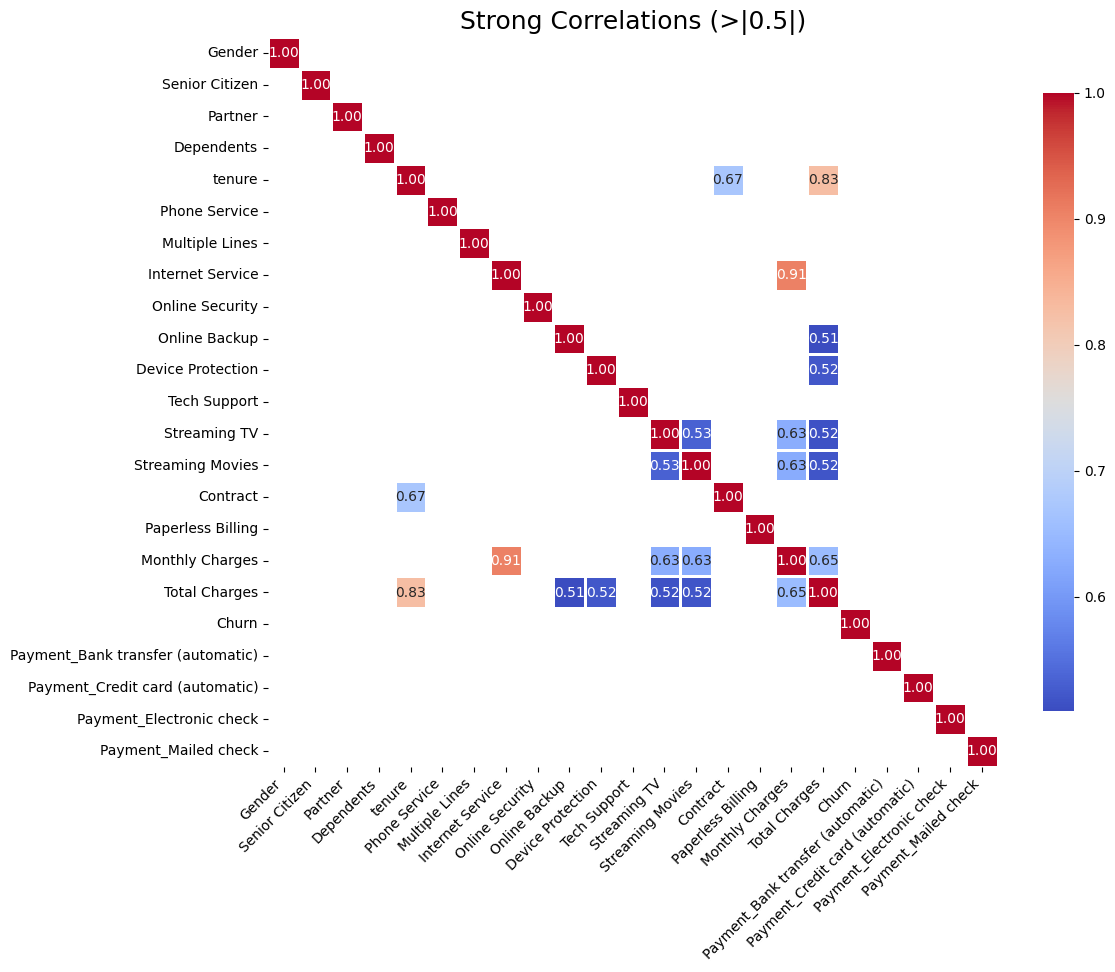

In [20]:
# Correlation matrix
plt.figure(figsize=(12, 10))

correlation = df.corr(numeric_only=True)
filtered_corr = correlation.where(np.abs(correlation) > 0.5)

sns.heatmap(
    filtered_corr, 
    cmap='coolwarm', 
    annot=True, 
    fmt=".2f", 
    linewidths=1, 
    square=True, 
    cbar_kws={"shrink": 0.8},
    annot_kws={"size": 10}
)

plt.title('Strong Correlations (>|0.5|)', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


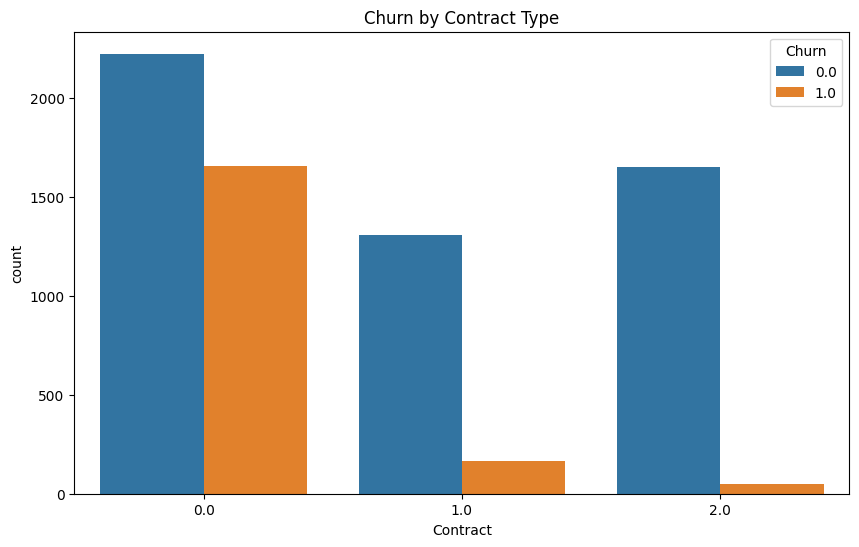

In [21]:
# Some key visualizations
plt.figure(figsize=(10, 6))
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title('Churn by Contract Type')
plt.show()


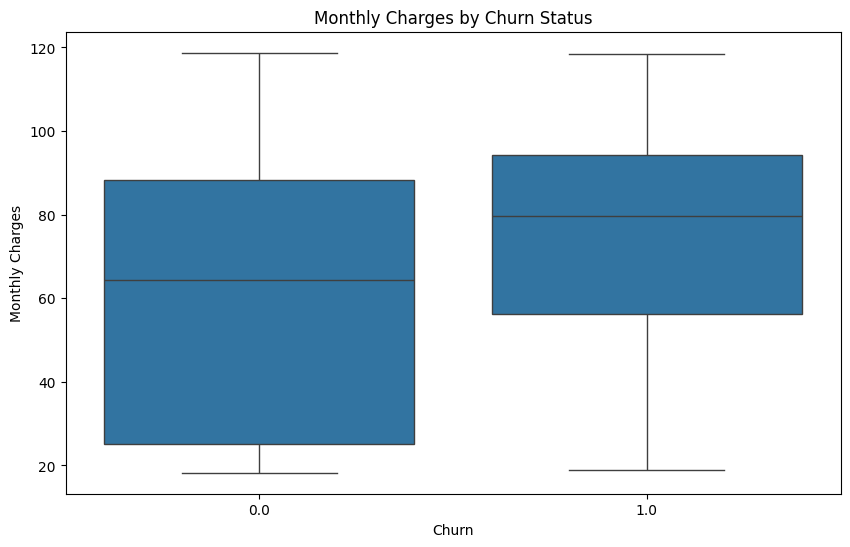

In [22]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='Monthly Charges', data=df)
plt.title('Monthly Charges by Churn Status')
plt.show()

In [23]:
# Prepare data for modeling
# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

In [24]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [25]:

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [26]:
# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

In [27]:
# Build the model with proper input shape specification
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

# Display the model architecture
model.summary()



c:\Users\nanyu\Desktop\Eve class\tensorflow_env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,585 (14.00 KB)

 Trainable params: 3,585 (14.00 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=test_dataset,
    callbacks=[early_stopping],
    verbose=1)

Epoch 1/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7068 - loss: 0.5633 - precision: 0.4278 - recall: 0.2315 - val_accuracy: 0.7935 - val_loss: 0.4267 - val_precision: 0.6930 - val_recall: 0.3984
Epoch 2/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7888 - loss: 0.4576 - precision: 0.6476 - recall: 0.4339 - val_accuracy: 0.8027 - val_loss: 0.4196 - val_precision: 0.6875 - val_recall: 0.4706
Epoch 3/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7935 - loss: 0.4345 - precision: 0.6455 - recall: 0.4770 - val_accuracy: 0.8034 - val_loss: 0.4191 - val_precision: 0.6790 - val_recall: 0.4920
Epoch 4/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7923 - loss: 0.4378 - precision: 0.6416 - recall: 0.4779 - val_accuracy: 0.8062 - val_loss: 0.4180 - val_precision: 0.6772 - val_recall: 0.5160
Epoch 5/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7962 - loss: 0.4334 - precision: 0.6419 - recall: 0.5088 - val_accuracy: 0.7999 - val_loss

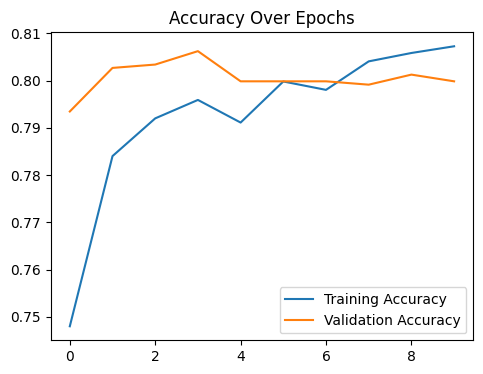

In [29]:
# Evaluate the model
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

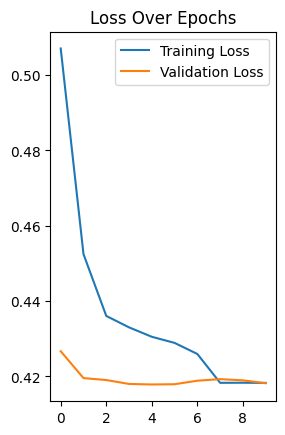

In [30]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

In [31]:
# Evaluate on test set
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_dataset)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

 1/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8438 - loss: 0.3711 - precision: 0.6000 - recall: 0.5000

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7934 - loss: 0.4232 - precision: 0.6661 - recall: 0.4628

Test Accuracy: 0.7999
Test Precision: 0.6643
Test Recall: 0.4973


In [32]:
# Predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [33]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87      1035
         1.0       0.66      0.50      0.57       374

    accuracy                           0.80      1409
   macro avg       0.75      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409



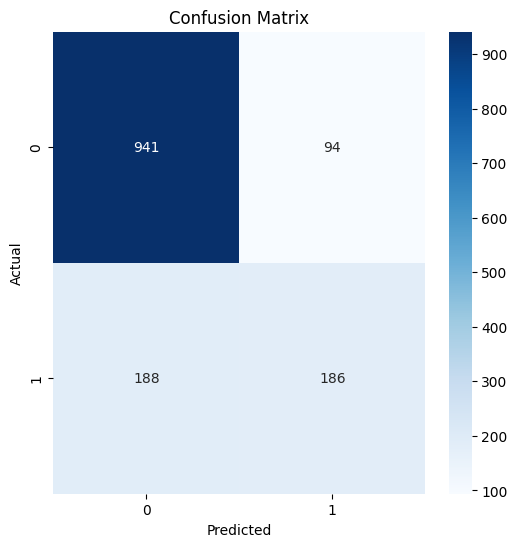

In [34]:
# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [35]:
# Save the model
model.save('churn_prediction_model.h5')

In [36]:
# Save the scaler
import joblib # type: ignore
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [37]:
# Reload the model and scaler
loaded_model = tf.keras.models.load_model('churn_prediction_model.h5')
loaded_scaler = joblib.load('scaler.pkl')

In [38]:
# Test reloaded model
sample_data = X_test[:1]  # Take one sample
scaled_sample = loaded_scaler.transform(sample_data)
prediction = loaded_model.predict(scaled_sample)
print(f"\nSample prediction: {prediction[0][0]:.4f} (Churn probability)")

c:\Users\nanyu\Desktop\Eve class\tensorflow_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step

Sample prediction: 0.0042 (Churn probability)
